In [3]:
import timeit

import numpy as np
import matplotlib.pyplot as plt 
import pandas

import CoolProp.CoolProp as CP
import CoolProp
print(CoolProp.__version__)
print(CoolProp.__gitrevision__)

import teqp
print(teqp.__version__)

6.4.2dev
64e27b95def8de50efcb560442eef0a0a3931a72
0.1.2


<IPython.core.display.Javascript object>


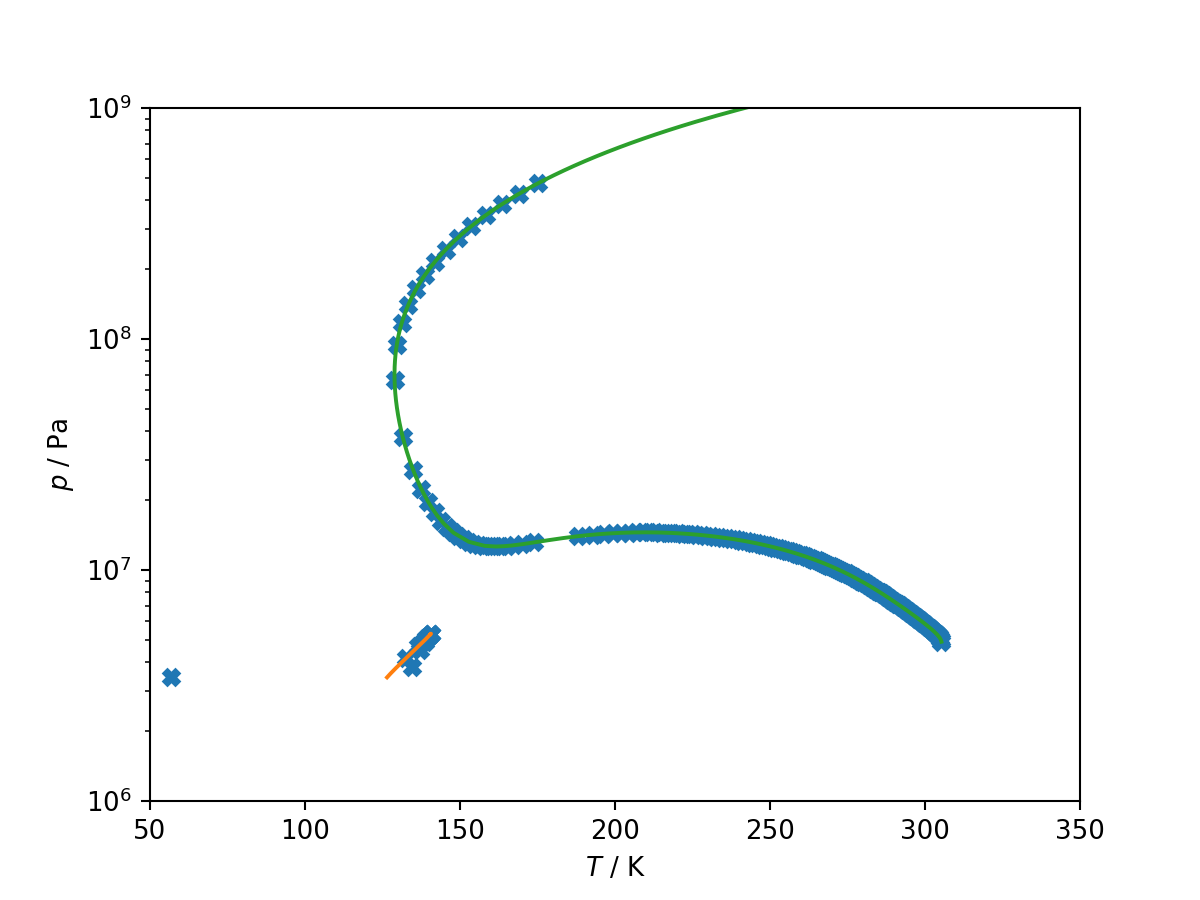

In [5]:
%matplotlib nbagg

# Note: running this block will take a while (a minute or more) because
# a whole lot of compositions are tried in order to construct a more 
# complete set of critical points

fname = 'N2C2_coolprop_crits.csv'
CP.set_config_bool(CP.ASSUME_CRITICAL_POINT_STABLE, True)

# Default model...
AS = CP.AbstractState('HEOS', 'Nitrogen&Ethane')
# Or this block is an option for PR+kij:
# AS = CP.AbstractState('PR', 'Nitrogen&Ethane')
# AS.set_binary_interaction_double(0,1,'kij',0.0515)
o = []
for x0 in np.linspace(0.001, 0.999, 201):
    AS.set_mole_fractions([x0, 1-x0])
    try:
        pts = AS.all_critical_points()
        for pt in pts:
            o.append({
                'x0': x0,
                'T / K': pt.T,
                'p / Pa': pt.p
            })    
    except BaseException as BE:
        pass
df = pandas.DataFrame(o)
df.to_csv(fname)

# Discrete points
df = pandas.read_csv(fname)
plt.plot(df['T / K'], df['p / Pa'], 'X')

def get_critical_curve(ipure):

    names = ['Nitrogen', 'Ethane']
    model = teqp.build_multifluid_model(names, '../mycp', '../mycp/dev/mixtures/mixture_binary_pairs.json')#,{'estimate':'Lorentz-Berthelot'})

    tic = timeit.default_timer()
    T0 = CP.PropsSI('Tcrit', names[ipure])
    rho0 = [CP.PropsSI('rhomolar_critical', names[ipure])]*2
    rho0[1-ipure] = 0
    curveJSON = teqp.trace_critical_arclength_binary(model, T0, rho0, "")
    toc = timeit.default_timer()
    df = pandas.DataFrame(curveJSON)
    df['z0 / mole frac.'] = df['rho0 / mol/m^3']/(df['rho0 / mol/m^3']+df['rho1 / mol/m^3'])
    return df

for ipure in [0,1]:
    df = get_critical_curve(ipure)
    plt.plot(df['T / K'], df['p / Pa'], '-')

plt.xlim(50, 350)
plt.ylim(1e6, 1e9)
plt.gca().set(xlabel='$T$ / K', ylabel='$p$ / Pa')
plt.yscale('log')
plt.show()